# Parallelization for Microscopic Image Deconvolution

### Import related packages

In [235]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as image
from PIL import Image
import math
import cv2
from time import time
from numba import cuda
from skimage import color
from scipy.signal import convolve

### Load image and display related information

In [236]:
img_org = cv2.imread('../data/test_nuclei_000004.jpg')
img = color.rgb2gray(img_org)

nx, ny = img.shape
print('Dimentions:', nx, "*", ny)
print(img.dtype)

Dimentions: 1000 * 1025
float64


### Define Richardson-Lucy algorithm
Code largely borrowed from skimage.restorian package, not parallelized

In [237]:
def richardson_lucy(image, psf, num_iter=50):
   """Richardson-Lucy deconvolution.

   Parameters
   ----------
   image : ndarray
      Input degraded image (can be N dimensional).
   psf : ndarray
      The point spread function.
   num_iter : int, optional
      Number of iterations. This parameter plays the role of
      regularisation.

   Returns
   -------
   im_deconv : ndarray
      The deconvolved image.

   References
   ----------
   [1] https://en.wikipedia.org/wiki/Richardson%E2%80%93Lucy_deconvolution
   [2] https://scikit-image.org/docs/stable/auto_examples/filters/plot_deconvolution.html
   """
   im_deconv = np.full(image.shape, 0.5, dtype=image.dtype)
   psf_mirror = np.flip(psf)

   # Small regularization parameter used to avoid 0 divisions
   eps = 1e-12

   for _ in range(num_iter):
      conv = convolve(im_deconv, psf, mode='same', method='direct') + eps
      relative_blur = image/conv
      im_deconv *= convolve(relative_blur, psf_mirror, mode='same', method='direct')
   
   im_deconv[im_deconv > 1] = 1
   im_deconv[im_deconv < -1] = -1

   return im_deconv

### Results and time consumed for traditional R-L deconvolution algorithm

CPU: Richardson_lucy execution time:  57.27786993980408 s


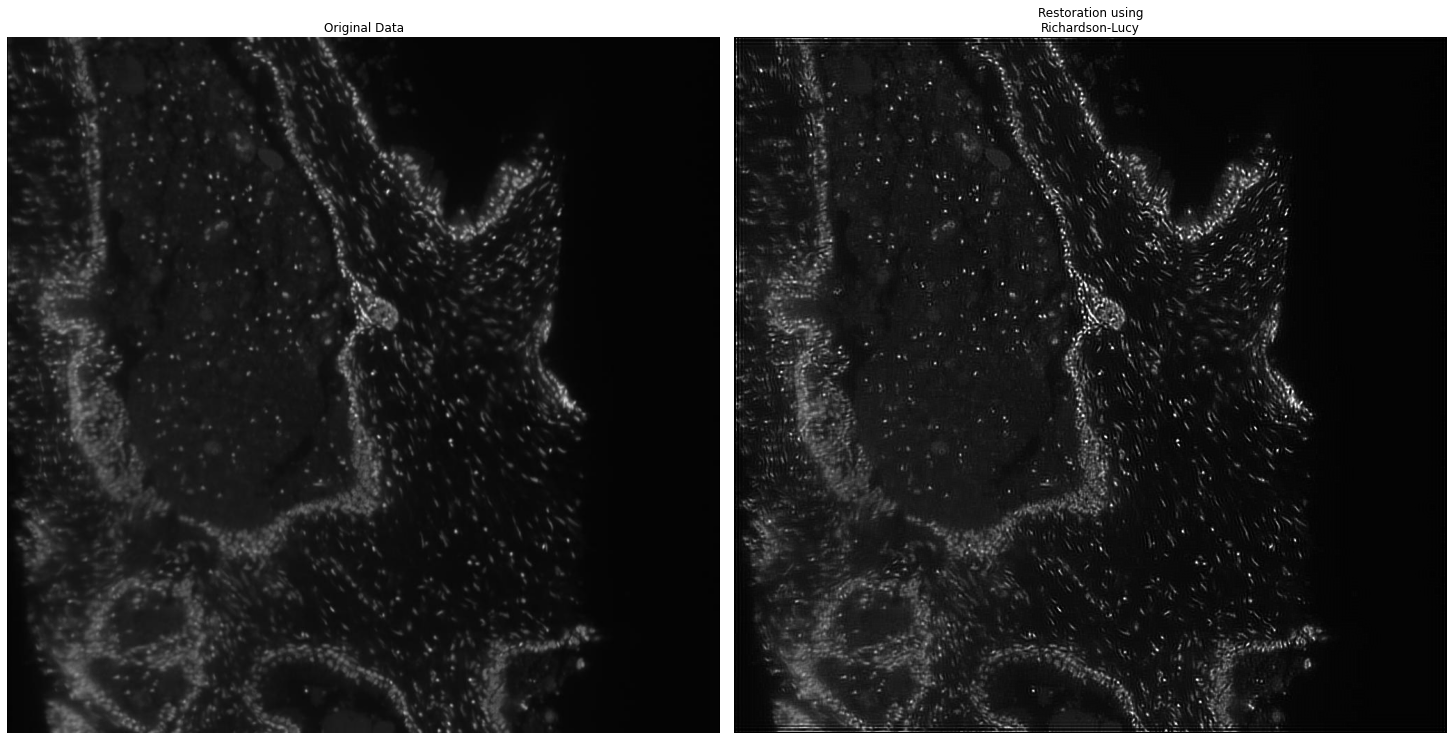

In [238]:
img = color.rgb2gray(cv2.imread('../data/test_nuclei_000004.jpg'))
psf = np.ones((5, 5))/25

# Restore Image using Richardson-Lucy algorithm
start = time()
deconvolved_RL = richardson_lucy(img, psf)
end = time()
elapsed = end - start
print("CPU: Richardson_lucy execution time: ", elapsed, "s")

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 12))
plt.gray()

for a in (ax[0], ax[1]):
       a.axis('off')

ax[0].imshow(img)
ax[0].set_title('Original Data')

ax[1].imshow(deconvolved_RL)
ax[1].set_title('Restoration using Richardson-Lucy')


fig.subplots_adjust(wspace=0.02, hspace=0.2,
                    top=0.9, bottom=0.05, left=0, right=1)
plt.show()
image.imsave(('../data/test_nuclei_000004_decon.jpg'), deconvolved_RL)

### Parallelize the convolution algorithm

In [239]:
TPB = 16
RAD = 1
# SH_N = 18

@cuda.jit
def conv_kernel(d_v, d_u):
    """
    Compute the updated convolution array based on the 9-point stencil \
    based on global memory arrays.
    
    Arguments:
        d_v: 2D float device array of updated values
        d_u: 2D float device array of current values
    returns:
        None
    """

    i, j = cuda.grid(2)
    dims = d_u.shape

    if RAD <= i <= dims[0] - 1 - RAD and RAD <= j <= dims[1] - 1 - RAD:
        d_v[i, j] = 0.4*d_u[i,j] + 0.4*d_u[i-1, j] + 0.4*d_u[i+1,j] + 0.4*d_u[i,j -1] + 0.4*d_u[i, j+1] + 0.4*d_u[i-1, j-1] + 0.4*d_u[i-1, j+1] + 0.4*d_u[i+1, j-1] + 0.4*d_u[i+1, j+1]


def conv_par(u, iter_count, memspec='global'):
    """
    Wrapper function for computing convolution using 9-point stencil.
    
    Arguments:
        u: numpy float 2D array of current image
        iter_count: int number of update iterations
        memspec: string; set memspec='shared' for updates based on shared memory kernel 
    Returns:
        convoluted 2D array of image
    """

    d_u = cuda.to_device(u)
    d_v = cuda.to_device(u)
    dims = u.shape
    gridDims = [(dims[0] + TPB - 1)//TPB, (dims[1] + TPB - 1)//TPB]
    blockDims = [TPB, TPB]

    for k in range(iter_count):
        conv_kernel[gridDims, blockDims](d_v, d_u)
        conv_kernel[gridDims, blockDims](d_u, d_v)
        
    return d_u.copy_to_host()

### Plot the image before and after the convolution

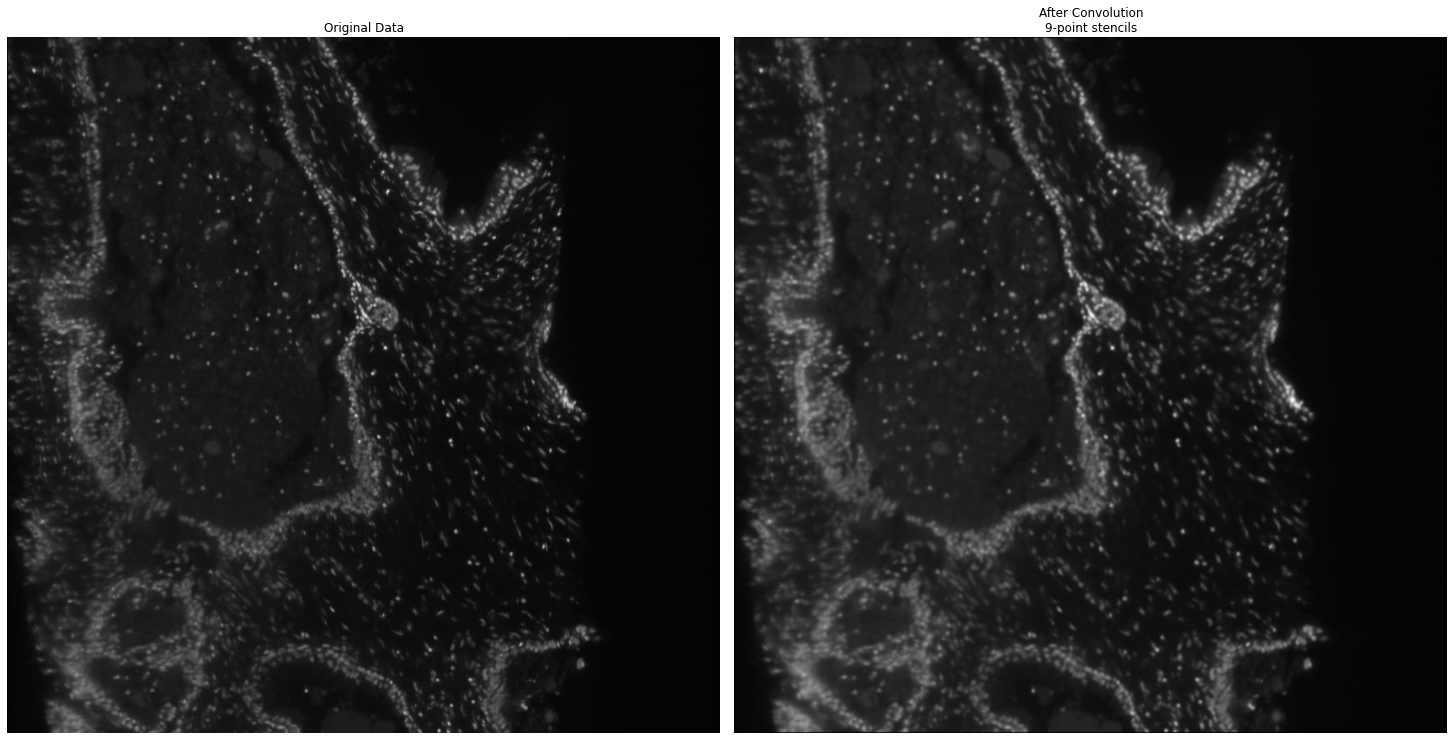

In [240]:
convolved = conv_par(img, 1)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 12))
plt.gray()
for a in (ax[0], ax[1]):
       a.axis('off')
ax[0].imshow(img)
ax[0].set_title('Original Data')
ax[1].imshow(convolved)
ax[1].set_title('After Convolution\n9-point stencils')

fig.subplots_adjust(wspace=0.02, hspace=0.2,
                    top=0.9, bottom=0.05, left=0, right=1)
plt.show()


In [241]:
TPB = 16
RAD = 1
# SH_N = 18

@cuda.jit
def conv_kernel25(d_v, d_u):
    """
    Compute the updated convolution array based on the 9-point stencil \
    based on global memory arrays.
    
    Arguments:
        d_v: 2D float device array of updated values
        d_u: 2D float device array of current values
    returns:
        None
    """
    i,j = cuda.grid(2)
    dims = d_u.shape

    if RAD <= i <= dims[0] - 1 - RAD and RAD <= j <= dims[1] - 1 - RAD:
        d_v[i, j] = 0.04*d_u[i,j] +\
                    0.04*d_u[i-1, j] + 0.04*d_u[i+1,j] +0.04*d_u[i,j-1] + 0.04*d_u[i, j+1] +\
                    0.04*d_u[i-1, j-1] + 0.04*d_u[i-1, j+1] + 0.04*d_u[i+1, j-1] + 0.04*d_u[i+1, j+1] +\
                    0.04*d_u[i-2, j] + 0.04*d_u[i+2, j] + 0.04*d_u[i, j-2] + 0.04*d_u[i, j+2] +\
                    0.04*d_u[i-1, j-2] + 0.04*d_u[i-1, j+2] + 0.04*d_u[i+1, j-2] + 0.04*d_u[i+1, j+2] +\
                    0.04*d_u[i-2, j-1] + 0.04*d_u[i-2, j+1] + 0.04*d_u[i+2, j-1] + 0.04*d_u[i+2, j+1] +\
                    0.04*d_u[i-2, j-2] + 0.04*d_u[i-2, j+2] + 0.04*d_u[i+2, j-2] + 0.04*d_u[i+2, j+2]

def conv25(u, iter_count, memspec='global'):
    """
    Wrapper function for computing convolution using 25-point stencil.
    
    Arguments:
        u: numpy float 2D array of current image
        iter_count: int number of update iterations
        memspec: string; set memspec='shared' for updates based on shared memory kernel 
    Returns:
        convoluted 2D array of image
    """
    
    d_u = cuda.to_device(u)
    d_v = cuda.to_device(u)
    dims = u.shape
    gridDims = [(dims[0] + TPB - 1)//TPB, (dims[1] + TPB - 1)//TPB]
    blockDims = [TPB, TPB]

    for k in range(iter_count):
        conv_kernel25[gridDims, blockDims](d_v, d_u)
        conv_kernel25[gridDims, blockDims](d_u, d_v)

    return d_u.copy_to_host()

### Implement the parallelized version of R-L algorithm

In [242]:
def rl_par(image, psf, num_iter=50):
   """Richardson-Lucy deconvolution.

   Arguments:
        image : ndarray
            Input degraded image (can be N dimensional).
        psf : ndarray
            The point spread function.
        num_iter : int, optional
            Number of iterations. This parameter plays the role of
            regularisation.

   Returns:
        im_deconv : ndarray
        The deconvolved image.

   References:
   [1] https://en.wikipedia.org/wiki/Richardson%E2%80%93Lucy_deconvolution
   [2] https://scikit-image.org/docs/stable/auto_examples/filters/plot_deconvolution.html
   """

   im_deconv = np.full(image.shape, 0.5, dtype=image.dtype)
#    psf_mirror = np.flip(psf)

   # Small regularization parameter used to avoid 0 divisions
   eps = 1e-12
   for _ in range(num_iter):
    #   conv = convolve(im_deconv, psf, mode='same',method='direct') + eps
      conv = conv25(im_deconv, 1) + eps
      relative_blur = image/conv
    #   im_deconv *= convolve(relative_blur, psf_mirror, mode='same',method='direct')
      conv = conv25(relative_blur, 1) #
      im_deconv *= conv

      
   im_deconv[im_deconv > 1] = 1
   im_deconv[im_deconv < -1] = -1

   return im_deconv

### Experiment of the parallelized deconvolution algorithm and time consumed

In [243]:
psf = np.ones((5, 5))/25
# print(psf)
start = time()
deconvolved_RL_v1 = rl_par(img, psf)
end = time()
elapsed_par = end - start
print("Global GPU: Richardson_lucy execution time: ", elapsed_par, "s")
print("Speedup factor: ", elapsed/elapsed_par)
device = cuda.get_current_device()
print(device)


Global GPU: Richardson_lucy execution time:  2.439495801925659 s
Speedup factor:  23.479388607510938
<CUDA device 0 'b'NVIDIA GeForce GTX 970M''>


### Plot the processed images

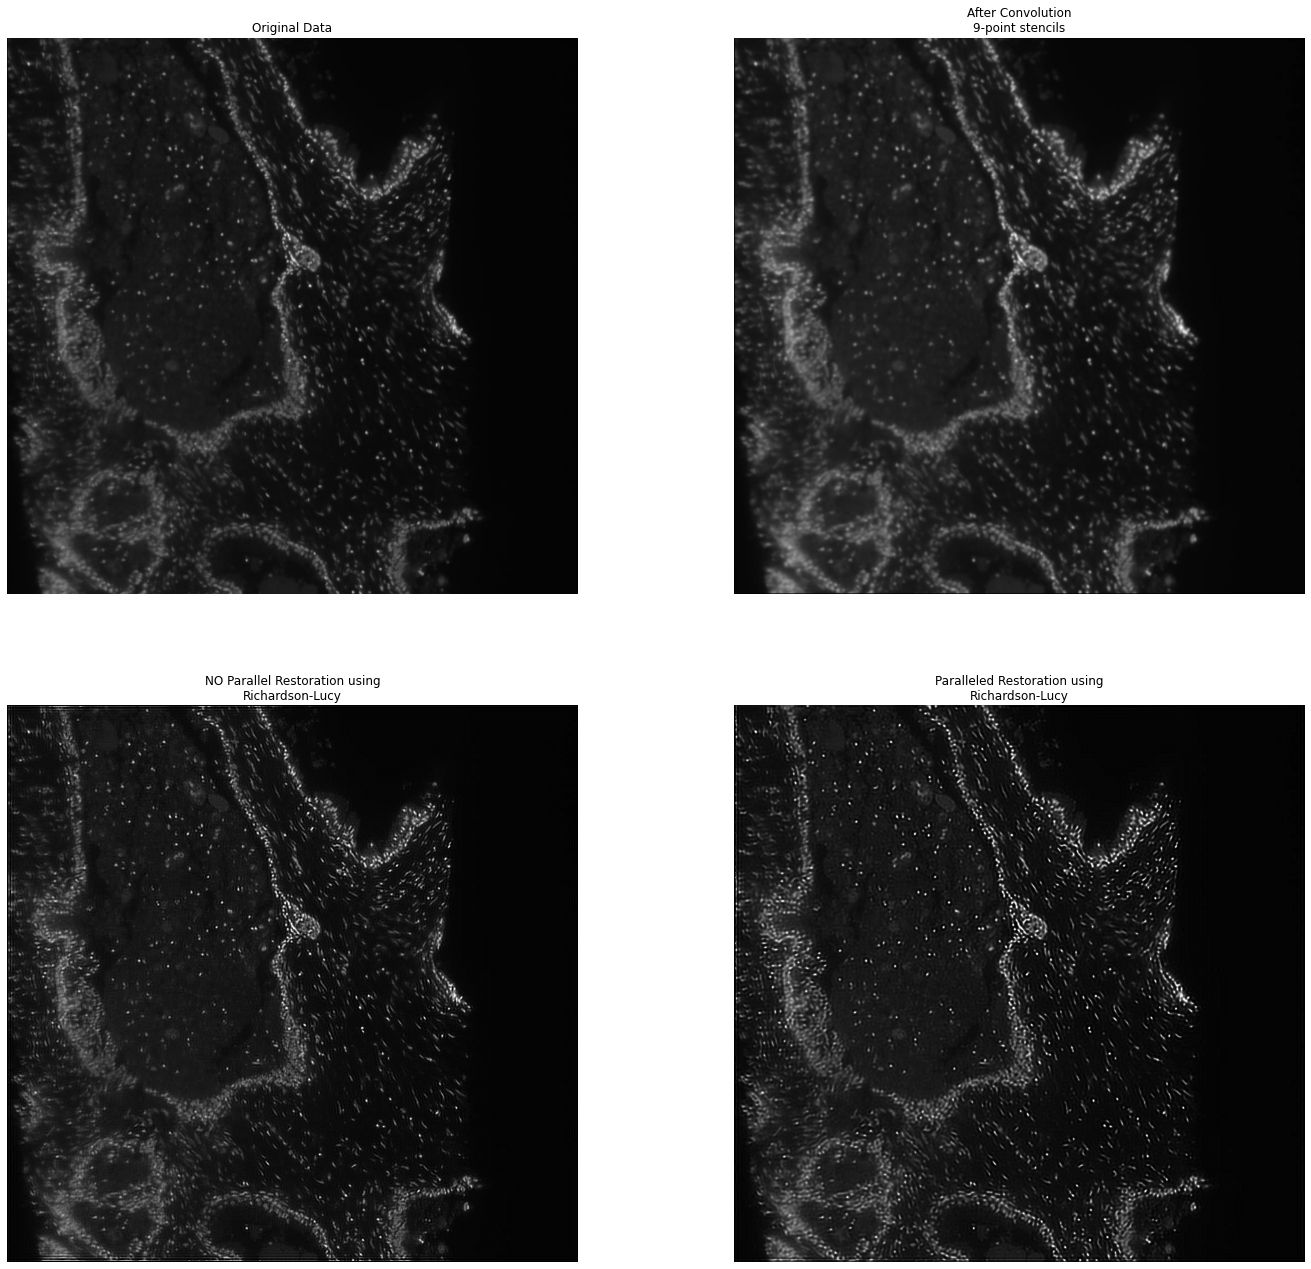

In [244]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))
plt.gray()

for a in (ax[0, 0], ax[0, 1], ax[1, 0], ax[1, 1]):
       a.axis('off')

ax[0, 0].imshow(img)
ax[0, 0].set_title('Original Data')

ax[0, 1].imshow(convolved)
ax[0, 1].set_title('After Convolution\n9-point stencils')

ax[1, 0].imshow(deconvolved_RL)
ax[1, 0].set_title('Non-Parallel Restoration using Richardson-Lucy')

ax[1, 1].imshow(deconvolved_RL_v1)
ax[1, 1].set_title('Parallelized Restoration using Richardson-Lucy')


fig.subplots_adjust(wspace=0.02, hspace=0.2,
                    top=0.9, bottom=0.05, left=0, right=1)
plt.show()
fig.savefig('../data/rl_parallel_compare.png')
image.imsave(('../data/test_nuclei_000004_decon_v1.jpg'), deconvolved_RL_v1)
